In [74]:

import os
os.chdir("/Users/davidamat/Documents/Projects/deepsetstats")

from deepsetstats.utils import utils_tools
from deepsetstats.utils import constants as c
from deepsetstats.utils import videocapture as vc

import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import copy
import torch
import time

In [75]:
%matplotlib inline
from importlib import reload
np.set_printoptions(threshold=2000)

In [76]:
utils_tools = reload(utils_tools)
c = reload(c)
vc = reload(vc)

In [77]:
# Constants



# 1. Load Videos and Dictionary of vids

In [78]:
# Dictionary of vids
extension = ".mp4"
gs = ["wb", "rg", "ao", "us"]

#c.PATH_VIDS = "/Users/davidamat/Documents/BackUp/DeepSetStats"
d_path_vids = {vid: str(Path(c.PATH_VIDS) / (vid + extension)) for vid in gs }
VC = vc.VideoClass(d_path_vids["rg"])
d_vc = { grandslam: vc.VideoClass(d_path_vids[grandslam]) for grandslam in gs}

# 2. Load frames

In [79]:
l_frames = [29*25, 29*25, 29*25, 25*25]
# in Color
d_f = {
   grandslam: d_vc[grandslam].get_frame(frame_num) for grandslam, frame_num in zip(gs, l_frames)
}

# In Black and White
d_fg = {
   grandslam: d_vc[grandslam]._correct_color(d_f[grandslam], gray=True) for grandslam in gs
}

# 3. Court Detection

In [348]:
# Input frame
tourn = "us"
frame = d_f[tourn].copy()
vt = d_vc[tourn]

## 3.1 Court Type

In [349]:
%%time
# Court type
rgb_court, court_type = VC.detect_court(frame)
print(f"Court Type: {court_type}")
print(f"Court RGB Colors: {c.D_GRAD_LINES[court_type]}")

Court Type: GREENSET_US
Court RGB Colors: {'COURT': array([100, 115, 159]), 'LINE_CLEAN': array([231, 233, 238]), 'LINE_DIRTY': array([193, 202, 224])}
CPU times: user 2.01 ms, sys: 695 µs, total: 2.71 ms
Wall time: 1.6 ms


## 3.2 White Filtering

In [350]:
%%time
#mask_lines = VC.get_line_mask(frame, court_type)
#VC.show_gray(mask_lines)
# VC.show_gray(mask_lines[500:600,200:300])

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [351]:
def shift_frame_up(img, pix_shift):
    return np.array(np.vstack((img[pix_shift:, :], img[-pix_shift:, :])), dtype=int)

def shift_frame_down(img, pix_shift):
    return np.array(np.vstack((img[:pix_shift, :], img[:-pix_shift, :])), dtype=int)

def shift_frame_left(img, pix_shift):
    return np.array(np.hstack((img[:, pix_shift:], img[:, -pix_shift:])), dtype=int)

def shift_frame_right(img, pix_shift):
    return np.array(np.hstack((img[:, :pix_shift], img[:, :-pix_shift])), dtype=int)

In [352]:
%%time
# Shift image upwards
pixels_shift_up = 6
pixels_shift_down = 6
pixels_shift_left = 6
pixels_shift_right = 6

frame_up = shift_frame_up(frame, pixels_shift_up)
frame_down = shift_frame_down(frame, pixels_shift_down)
frame_left = shift_frame_left(frame, pixels_shift_left)
frame_right = shift_frame_right(frame, pixels_shift_right)

CPU times: user 14.9 ms, sys: 6.76 ms, total: 21.6 ms
Wall time: 19.8 ms


In [353]:
%%time
frame_diff_up = np.mean(frame_up - frame, axis=2, dtype=int)
frame_diff_down = np.mean(frame_down - frame, axis=2, dtype=int)
frame_diff_left = np.mean(frame_left - frame, axis=2, dtype=int)
frame_diff_right = np.mean(frame_right - frame, axis=2, dtype=int)

CPU times: user 62.8 ms, sys: 9.68 ms, total: 72.5 ms
Wall time: 70.4 ms


In [354]:
#%%time
#frame_diff_up_to_down = shift_frame_down(frame_diff_up, pixels_shift_up)
#frame_diff_down_to_up = shift_frame_up(frame_diff_down, pixels_shift_down)

In [355]:
%%time
mask_lines_v = np.sqrt(np.abs(np.multiply(frame_diff_up, frame_diff_down)))
mask_lines_h = np.sqrt(np.abs(np.multiply(frame_diff_left, frame_diff_right)))
mask_lines = np.sqrt(np.multiply(mask_lines_v, mask_lines_h))

CPU times: user 13.1 ms, sys: 1.68 ms, total: 14.8 ms
Wall time: 12.5 ms


In [357]:
%%time
# Binarize mask
mask_lines_bin_v = mask_lines_v.copy()
mask_lines_bin_h = mask_lines_h.copy()
mask_lines_bin = np.maximum(mask_lines_bin_v, mask_lines_bin_h)

# Apply threshold
mask_idx = mask_lines_bin < 40
mask_lines_bin[mask_idx] = 1
mask_lines_bin[~mask_idx] = 0

CPU times: user 8.83 ms, sys: 1.7 ms, total: 10.5 ms
Wall time: 8.12 ms


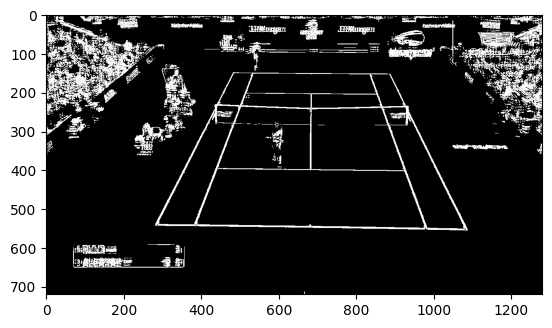

In [358]:
VC.show_gray(mask_lines_bin*255)

In [311]:
np.where(mask_lines_bin)[0].shape

(872938,)

In [306]:
sli = mask_lines_bin[625:645, 610:615]

In [307]:
sli.min(axis=1)

array([255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
         0.,   0.,   0., 255., 255., 255., 255., 255., 255.])

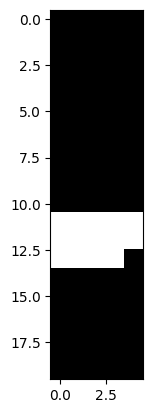

In [308]:
VC.show_gray(sli)

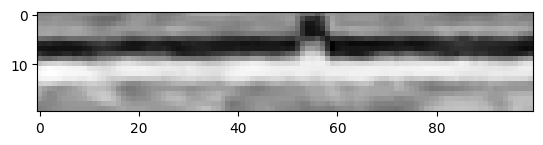

In [184]:
VC.show_gray(frame_diff_down[625:645, 600:700])

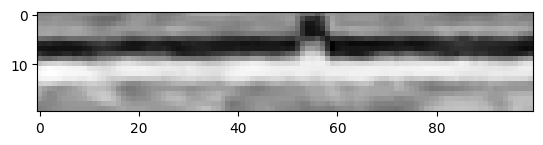

In [185]:
VC.show_gray(frame_diff_up[625:645, 600:700])

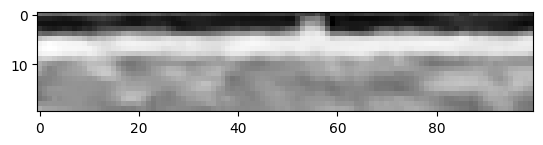

In [175]:
VC.show_gray(frame_diff_up_to_down[625:645, 600:700])

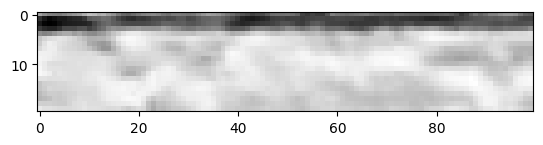

In [176]:
VC.show_gray(frame_diff_down_to_up[625:645, 600:700])

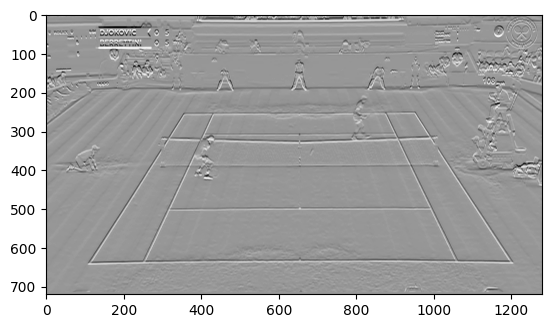

In [143]:
VC.show_gray(frame_diff_up)

In [106]:
np.max(frame_diff)

255.0

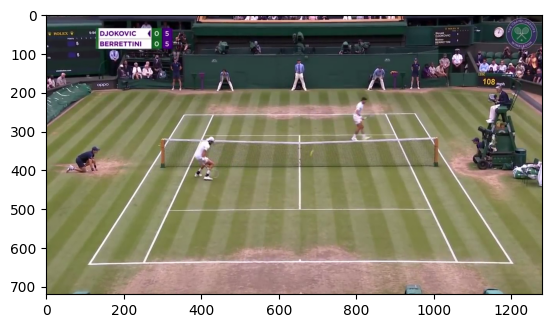

In [116]:
VC.show_frame(frame_down)